# AI Model for predicting future success of songs based on metrics - Harmony Hunt app (Jamendo API)


A binary classification model designed to predict whether a song will perform better based on certain features.

## Data Cleaning and preprocessing

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv("jamendo.csv")

# Drop the specified columns
columns_to_drop = ['headers__status', '' 'headers__code', 'headers__error_message', 'headers__warnings', 'headers__results_count', 'results__id', 'results__album_id', 'results__license_ccurl', 'results__position', 'results__album_image' , 'results__audio', 'results__audiodownload', 'results__prourl', 'results__image', 'results__shorturl' , 'results__shareurl', 'results__audiodownload_allowed', 'results__artist_idstr', 'results__artist_id', 'results__waveform','results__stats__avgnote','results__stats__notes']
df = df.drop(columns=columns_to_drop)

# Convert the 'results__releasedate' column to datetime
df['results__releasedate'] = pd.to_datetime(df['results__releasedate'])

# Create a new column 'released_on_weekend'
df['released_on_weekend'] = df['results__releasedate'].dt.weekday >= 5



df.head(100)


C:\Users\gupta\AppData\Local\Temp\ipykernel_15560\3157618111.py:19: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['results__releasedate'] = pd.to_datetime(df['results__releasedate'])


,results__name,results__duration,results__artist_name,results__album_name,results__releasedate,results__stats__rate_downloads_total,results__stats__rate_listened_total,results__stats__playlisted,results__stats__favorited,results__stats__likes,results__stats__dislikes,released_on_weekend
0,Colin Charisma - Good Things (Are Worth The Wait),139,Colin Charisma,Colin Charisma - Good Things (Are Worth The Wait),2024-01-30,0,18514,40,25,0,0,False
1,Rhythms of Love,252,Caleb Lemond,The Thing With Feathers,2024-01-19,395,17825,21,17,0,0,False
2,Stay with You,136,Decision Space,Awaking,2024-02-15,5,87,1,0,0,0,False
3,Colin Charisma - Best Days,198,Colin Charisma,Colin Charisma - Best Days,2024-01-30,0,220,3,2,0,0,False
4,Living My Fantasy,177,Ed Napoli,Living My Fantasy,2024-01-22,2,821,4,1,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Apocalypse Dub,266,Lackaday!,Apocalypse Dub,2024-02-20,1,101,0,0,0,0,False
96,Truth is - Lounge Mix,157,Suzy E,Catchy Syngers - Part 36,2024-03-11,0,76,0,0,0,0,False
97,Watching Birds Fly,199,Silver-Stage,THE EDM VOLUME 7,2024-01-22,0,13,0,0,0,0,False
98,Буря вдалеке,284,Chalmer-Ju,Few cold drops,2024-03-19,0,0,0,0,0,0,False


## Target variable definition and identifying features for training 

perform_better
False    84
True     16
Name: count, dtype: int64


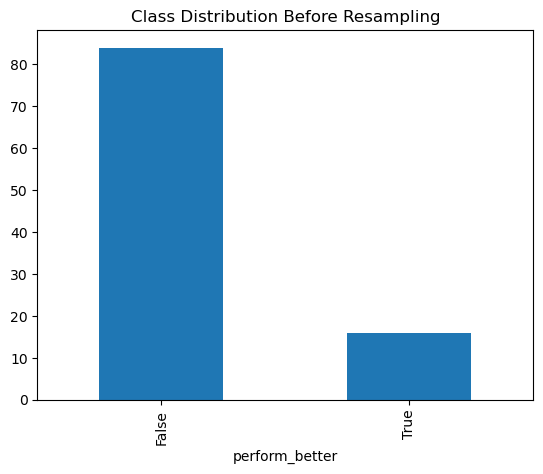

In [4]:
# Define the target variable
df['perform_better'] = (df['results__duration'] > 10) & (df['results__stats__playlisted'] > 1)

# Examining the distribution of target variable before the resampling process
class_counts = df['perform_better'].value_counts()
print(class_counts)

# Plot the distribution of target variable before the resampling process
class_counts.plot(kind='bar', title='Class Distribution Before Resampling')
plt.show()

# Define the features (the information to make the prediction)
features = df[['results__duration', 'results__stats__rate_downloads_total', 'results__stats__favorited', 'results__stats__likes', 'results__stats__dislikes', 'released_on_weekend']]

## Handing class imbalances 

perform_better
False    84
True     42
Name: count, dtype: int64


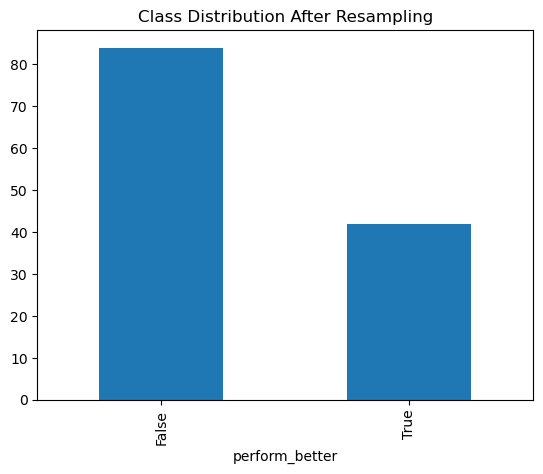

In [5]:
# Define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.5)

# Define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)

# Define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Fit and apply the pipeline
X_resampled, y_resampled = pipeline.fit_resample(features, df['perform_better'])

# Print the count of each class in the resampled data
resampled_class_counts = pd.Series(y_resampled).value_counts()
print(resampled_class_counts)

# Plot the distribution of target variable after the resampling process
resampled_class_counts.plot(kind='bar', title='Class Distribution After Resampling')
plt.show()




## Model building and evaluation

Accuracy: 0.9230769230769231
Precision: 0.7777777777777778
Recall: 1.0
F1 Score: 0.8750000000000001
ROC AUC Score: 0.9473684210526316


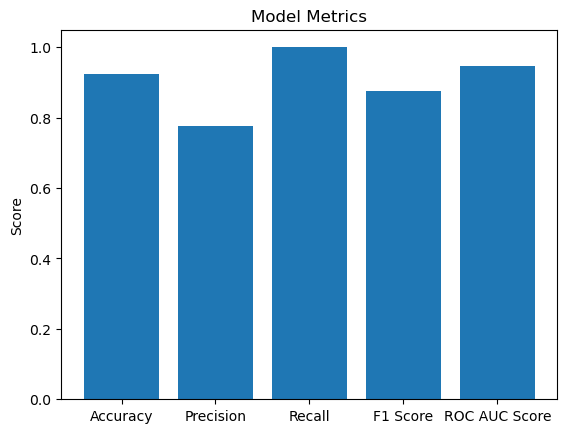

In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=32)

# Create and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=12)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Measure the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Measure the precision of the model
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Measure the recall of the model
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# Measure the F1 score of the model
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Measure the Area Under the ROC Curve
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC Score: {roc_auc}')

# Plot the metrics
metrics = [accuracy, precision, recall, f1, roc_auc]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score']

plt.bar(metric_names, metrics)
plt.title('Model Metrics')
plt.ylabel('Score')
plt.show()

In [7]:
# Use the model to make predictions on the entire dataset
df['predicted_perform_better'] = clf.predict(features)

# Filter the DataFrame to only include songs that the model predicts will perform better
predicted_hits = df[df['predicted_perform_better'] == True]

# Print the names and artist of the predicted hit songs
print(predicted_hits[['results__name', 'results__artist_name']])

                                        results__name  \
0   Colin Charisma - Good Things (Are Worth The Wait)   
1                                     Rhythms of Love   
3                          Colin Charisma - Best Days   
4                                   Living My Fantasy   
5                                              Scared   
6                                          Your Smile   
11                                           Madeline   
13                             Good Time Past So Fast   
14  Volta pra casa (feat. Marina Marchi, Pedro Vas...   
19                                          Right Map   
26                      Colin Charisma - Stratosphere   
29                                       O sol chegou   
32                                       Polite Rebel   
46                                               Moth   
47                                                 go   
64                   Niki J Crawford - You Are Enough   
68                            A

## Feature importance plot

 The feature importance plot helps to understand which features were 
 most influential in the model’s predictions.

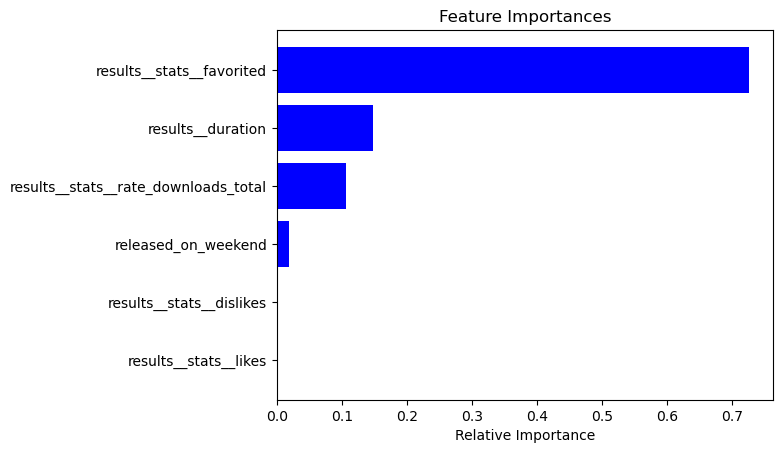

In [8]:
# Plot feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()